# Tarea 3: Detección de Sarcasmo
## IIC2613 - Inteligencia Artificial
### Rafael Fernández

---

## Lbrerías usadas

In [16]:
import json
import random
import matplotlib.pyplot as plt
import numpy as np
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Funciones de Utilidad

In [17]:
def parse_data(filename):
    items = []
    with open(filename, encoding="utf-8") as file:
        for line in file:
            line = line.strip()
            items.append(json.loads(line))
    return items

def remove_non_letters(items):
    """Elimina comillas y puntuaciones de los titulares"""
    for item in items:
        head = item["headline"]
        item["headline"] = head.replace("'", "").replace(":", "")
    return items


def split_headline_class(items):
    heads = [item["headline"] for item in items]
    classes = [item["is_sarcastic"] for item in items]
    return heads, classes

def remove_stopwords(heads):
    clean = []
    for title in heads:
        new_title  = " ".join([word for word in title.split() 
                            if word.lower() not in STOP_WORDS])
        clean.append(new_title)

    return clean

def gen_barplot(x_data, y_data, x_label="", y_label="", title="", rotate_x=False):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x_data, y_data)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

    if rotate_x:
        plt.xticks(rotation='vertical')

    plt.show()

def get_word_freqs(heads):
    words = " ".join(heads).split()

    counts = {}
    for word in words:
        if word not in counts:
            counts[word] = 1
        else:
            counts[word] += 1

    counts_tups = [(word, count) for word, count in counts.items()]
    counts_tups.sort(reverse=True, key=lambda tup: tup[1])
    return counts_tups

def train_validation_test(x_data, y_data, validation_prop, test_prop):
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                        test_size=test_prop, random_state=1)
    new_prop = validation_prop / (1 - test_prop)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, 
                                                      test_size=new_prop, random_state=1)
    
    return x_train, x_val, x_test, y_train, y_val, y_test


## Importar y limpiar base de datos

In [18]:

FILENAME = "Sarcasm_Headlines_Dataset_v2.json"

random.seed(1)
# Definiremos un parámetro para limitar la cantidad de registros que usar
ITEM_LIMIT = 2500

items = parse_data(FILENAME)
print("Cantidad total", len(items))
print("Cantidad muestra", ITEM_LIMIT)
items = random.sample(items, ITEM_LIMIT)
items = remove_non_letters(items)
heads, classes = split_headline_class(items)

Cantidad total 28619
Cantidad muestra 2500


También obtendremos los titulares sin stop words para luego comparar los resultados

In [19]:
heads_clean = remove_stopwords(heads)

## Creación de sets de entrenamiento, validación y test

In [20]:
ans = train_validation_test(heads, classes, 0.15, 0.15)
x_train, x_val, x_test, y_train, y_val, y_test = ans

In [21]:
ans = train_validation_test(heads_clean, classes, 0.15, 0.15)
x_train_clean, x_val_clean, x_test_clean, y_train_clean, y_val_clean, y_test_clean = ans
   

In [22]:
# Save variables for later
x_test_original = x_test
x_test_clean_original = x_test_clean

## Actividad 1: Palabras más usadas

In [23]:
BAR_LIMIT = 70

Primero veremos las palabras más usadas en los titulares con *stopwords*

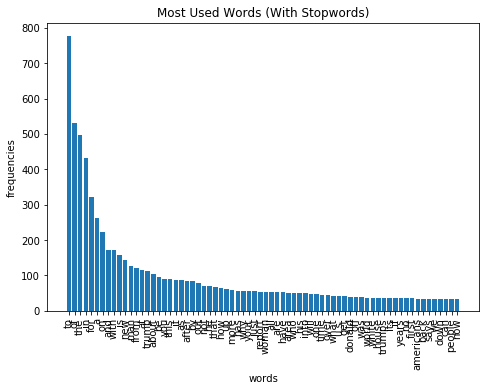

In [24]:
counts = get_word_freqs(heads)[:BAR_LIMIT]
x_data = [tup[0] for tup in counts]
y_data = [tup[1] for tup in counts]

title = "Most Used Words (With Stopwords)"
gen_barplot(x_data, y_data, "words", "frequencies", title, True)


Ahora visualizaremos las palabras mas usadas **sin** *stopwords*

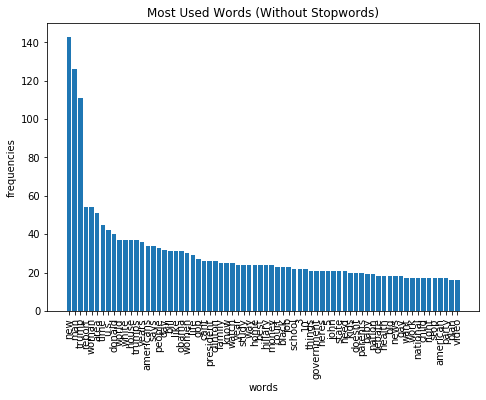

In [25]:
counts = get_word_freqs(heads_clean)[:BAR_LIMIT]
x_data = [tup[0] for tup in counts]
y_data = [tup[1] for tup in counts]

title = "Most Used Words (Without Stopwords)"
gen_barplot(x_data, y_data, "words", "frequencies", title, True)

Como podemos ver, para titulares con *stopwords*, obtuvimos que (como era de esperarse) las palabras más utilizadas son stop words, siendo 'to', 'of', 'the', 'in', 'for' las más utilizadas.

Para el caso de los titulares sin *stopwords*, podemos ver que las 3 palabras más utilizadas, superando ampliamente a las demás son: 'new', 'man' y 'trump'. Además, podemos ver una fuerte presencia de nombres de políticos en los titulares: 'donald', 'trump', 'hillary', 'bill', 'clinton'.

## Actividad 2: Estrategia de Preprocesamiento

La estrategia a utilizar será **Bag of Words**.
Esta es una técnica donde cada frase se convierte en un vector donde cada dimension representa la cantidad de cada palabra presente en la frase. Cada vector tiene un número de dimensiones igual a la cantidad de palabras disntitas entre todos los titulares y, como se dijo anteriormente, la i-esima dimensión de cada vector guarda la frecuencia de una palabra del total de palabras distintas.

Ya que solo se guardan frecuencias de cada palabra, la gramática de cada frase se pierde. Por lo tanto, distintos titulares podrían tener la misma representación vectorial.

Este método se considera como una manera simple de representar la información de un texto.




A continuación crearemos los vectores a partir de los titulares con y sin *stopwords* mediante la librería sklearn.

In [26]:
vectorizer = CountVectorizer()
vectorizer.fit(heads)

x_train = vectorizer.transform(x_train)
x_val = vectorizer.transform(x_val)
x_test = vectorizer.transform(x_test)



In [27]:
vectorizer = CountVectorizer()
vectorizer.fit(heads_clean)

x_train_clean = vectorizer.transform(x_train_clean)
x_val_clean = vectorizer.transform(x_val_clean)
x_test_clean = vectorizer.transform(x_test_clean)

## Actividad 3: Clasificación con SVM

A continuación entrenaremos varios SVM con variados parámetros y determinaremos que parámetros permiten obtener el mejor rendimiento.

Probaremos cada uno de los tres *kernels* propuestos en el enunciado con cada uno de los valores de *C* propuestos, explicados a continuación.

En base al paper "A Practical Guide to Support Vector Classification" de Chih-Wei Hsu. et al, valores recomendados para probar con el valor de *C* los de la sucesión 2^-5, 2^-3, ..., 2^15.

In [28]:
c_exponents = [x for x in range(-5, 17, 2)]
kernels = ['rbf', 'poly', 'linear']


results_train = []
results_validation = []

for kernel in kernels:
    result_train_row = []
    result_validation_row = []
    for exponent in c_exponents:
        print(f"Calculando para C = 2^{exponent} y kernel = {kernel}")
        classifier = SVC(C=2**exponent, kernel=kernel, gamma="auto")
        classifier.fit(x_train_clean, y_train_clean)
        
        y_pred = classifier.predict(x_train_clean)
        accuracy = round(accuracy_score(y_train_clean, y_pred), 3)
        result_train_row.append(accuracy)

        y_pred = classifier.predict(x_val_clean)
        accuracy = round(accuracy_score(y_val_clean, y_pred), 3)
        result_validation_row.append(accuracy)
        # print(classification_report(y_val_clean, y_pred))
        # print(accuracy_score(y_val_clean, y_pred))
        # print("-" * 30 + "\n")

    results_validation.append(result_validation_row)
    results_train.append(result_train_row)




Calculando para C = 2^-5 y kernel = rbf
Calculando para C = 2^-3 y kernel = rbf
Calculando para C = 2^-1 y kernel = rbf
Calculando para C = 2^1 y kernel = rbf
Calculando para C = 2^3 y kernel = rbf
Calculando para C = 2^5 y kernel = rbf
Calculando para C = 2^7 y kernel = rbf
Calculando para C = 2^9 y kernel = rbf
Calculando para C = 2^11 y kernel = rbf
Calculando para C = 2^13 y kernel = rbf
Calculando para C = 2^15 y kernel = rbf
Calculando para C = 2^-5 y kernel = poly
Calculando para C = 2^-3 y kernel = poly
Calculando para C = 2^-1 y kernel = poly
Calculando para C = 2^1 y kernel = poly
Calculando para C = 2^3 y kernel = poly
Calculando para C = 2^5 y kernel = poly
Calculando para C = 2^7 y kernel = poly
Calculando para C = 2^9 y kernel = poly
Calculando para C = 2^11 y kernel = poly
Calculando para C = 2^13 y kernel = poly
Calculando para C = 2^15 y kernel = poly
Calculando para C = 2^-5 y kernel = linear
Calculando para C = 2^-3 y kernel = linear
Calculando para C = 2^-1 y kernel

La exactitud de predicción para el set de entrenamiento fue la siguiente:

In [29]:

print(("Kernel / C" + "{:>8}" * len(c_exponents)).format(*[f"2^{x}" for x in c_exponents]))
for index, values in enumerate(results_train):
    print(("{:<9} " + "{:>8}" * len(c_exponents)).format(kernels[index], *values))

Kernel / C    2^-5    2^-3    2^-1     2^1     2^3     2^5     2^7     2^9    2^11    2^13    2^15
rbf          0.522   0.522   0.522   0.522   0.522   0.535   0.667   0.974   0.999     1.0     1.0
poly         0.522   0.522   0.522   0.522   0.522   0.522   0.522   0.522   0.522   0.522   0.522
linear       0.641    0.97   0.999     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0


Mientras que los resultados para el set de validación fueron los siguientes

In [30]:

print(("Kernel / C" + "{:>8}" * len(c_exponents)).format(*[f"2^{x}" for x in c_exponents]))
for index, values in enumerate(results_validation):
    print(("{:<9} " + "{:>8}" * len(c_exponents)).format(kernels[index], *values))

Kernel / C    2^-5    2^-3    2^-1     2^1     2^3     2^5     2^7     2^9    2^11    2^13    2^15
rbf          0.576   0.576   0.576   0.576   0.576   0.584   0.645   0.707   0.712   0.712   0.709
poly         0.576   0.576   0.576   0.576   0.576   0.576   0.576   0.576   0.576   0.576   0.576
linear       0.632   0.723   0.715   0.715   0.709   0.704   0.693   0.693   0.693   0.693   0.693


Se puede ver que, como era de esperar, los resultados en el set de training fueron, generalmente, mejores que en el set de validación.
Para el caso del set de training, se ve que al aumentar el valor de *C*, en los kernels *rbf* y *linear*, la exactitud de predicción aumenta, logrando llegar separar correctamente todas las clases (Exactitud 1.0). Esto puede ser considerado como un caso de *overfitting*.

Además, notar que en ambos sets se obtuvieron resultados similares para el kernel *poly* y que los resultados eran independientes de *C*, lo cual puede ser causado por que no se varió el grado del polinomio.

Finalmente, en el set de validación se puede notar que los kernels *linear* y *rbf* tienen un rendimiento similar, donde *linear* rinde mejor en valores bajos de *C*.

## Actividad 4: Análisis de SVM

Según los resultados de la sección anterior, podemos ver que el mejor rendimiento en el set de validación se logra con el kernel ** *rbf* ** y con un valor de ** *C* ** igual a 2^11.
La exactitud de predicción en dicho caso fue de **71.2%**.

A continuación se probará el rendimiento con el set de test.

In [31]:
classifier = SVC(C=2**9, kernel="rbf", gamma="auto")
classifier.fit(x_train_clean, y_train_clean)
y_pred = classifier.predict(x_test_clean)
accuracy = round(accuracy_score(y_test_clean, y_pred), 3)
print(f"Rendimiento en set de test: {accuracy}")


Rendimiento en set de test: 0.693


Ahora buscaremos cuales son los titulares que pudo predeccir correctamente y cuales no.

In [32]:
correct = [(val, y_test[index]) for index, val in enumerate(x_test_original) 
           if y_pred[index] == y_test[index]]

correct_true = [title for title, class_ in correct if class_]
correct_false = [title for title, class_ in correct if not class_]

incorrect = [(val, y_test[index]) for index, val in enumerate(x_test_original)
             if y_pred[index] != y_test[index]]
incorrect_true = [title for title, class_ in incorrect if class_]
incorrect_false = [title for title, class_ in incorrect if not class_]

In [33]:
LIMIT = 10

print("---- CORRECTAMENTE CLASIFICADAS -----")
print("---> IRÓNICAS")
print("\n".join(correct_true[:LIMIT]) + "\n")
print("---> NO IRÓNICAS")
print("\n".join(correct_false[:LIMIT]) + "\n")
print("-" * 40 + "\n")
print("---- INCORRECTAMENTE CLASIFICADAS -----")
print("---> IRÓNICAS")
print("\n".join(incorrect_true[:LIMIT]) + "\n")
print("---> NO IRÓNICAS")
print("\n".join(incorrect_false[:LIMIT]) + "\n")


---- CORRECTAMENTE CLASIFICADAS -----
---> IRÓNICAS
romney we should never apologize for american values or japanese internment camps
nation to try channeling outrage over gun control into issue that can actually be addressed
outdoor movie guest excited to watch barely audible back to the future while sitting on tree root
obama returns from trade summit with 5 stout ships full of cardamom, silk, and indigo
shy congressman wishes other lawmakers would include him in their crimes
obama urges young voters to ignore how many lousy candidates democratic party runs
man wearing jewmerica t-shirt never dreamed hed see this day
department of agriculture locates perfect goat
biden forges presidents signature on executive order to make december dokken history month
report smart car terrible for doughnuts

---> NO IRÓNICAS
boardroom hokey pokey that dance that women do
supreme court justices to snowstorm jonas its just ice
white house probes kushner business loans after ethics questions
harry pott

Podemos ver que el rendimiento en el set de test, como era de esperar, es un poco inferior al del set de validación. La exactitud en el set de test fue de un **69.3%** vs el **71.2%** del set de validación. Cabe mencionar que estos resultados se obtuvieron solo con una fracción de la base de datos original, por lo que se espera que si entrenamos el modelo con la base de datos completa, el rendimiento será superior.

Por otra parte, si bien es difícil detectar patrones por los cuales el modelo hizo las clasificiaciones, parece ser que el modelo no logra detectar bien sarcasmos que no usan palabras relacionadas con la exageración como *never*, *full*, *perfect*, *terrible*, etc 



## Actividad 5: Redes Neuronales

In [34]:
# https://stackoverflow.com/questions/46912557/is-it-possible-to-get-test-scores-for-each-iteration-of-mlpclassifier

def train_and_plot(layers, x_train, y_train, x_test, y_test):
    mlp = MLPClassifier(hidden_layer_sizes=layers, max_iter=30)
    mlp.fit(x_train, y_train)
    y_pred = mlp.predict(x_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    # print("Cantidad de capas:", len(layers))
    # print("Neuronas por capa:", layers[0])
    # print("Rendimiento Obtenido:", accuracy)
    # print("Gráfico de pérdida en set de entrenamiento")
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.plot(mlp.loss_curve_)
    ax.set_title(f"Capas: {len(layers)}\nNeuronas por capa: {layers[0]}\nExactitud: {accuracy}")
    plt.show()


/home/rafael/.local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/rafael/.local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/rafael/.local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/rafael/.local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.ma

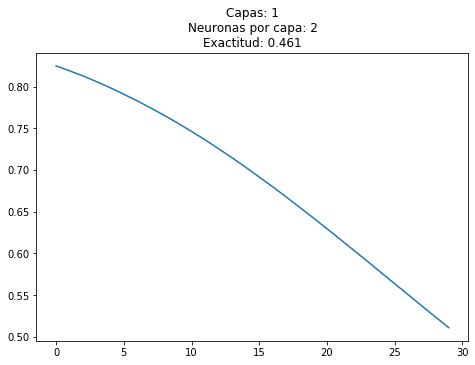

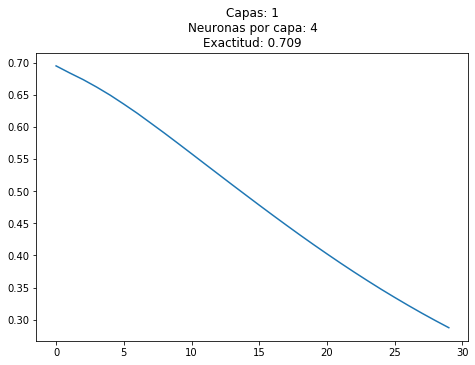

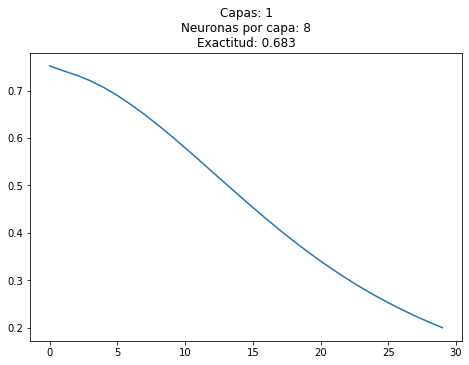

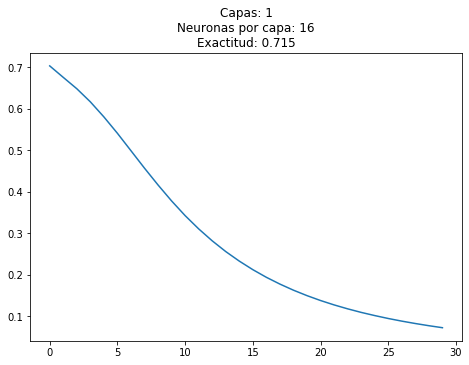

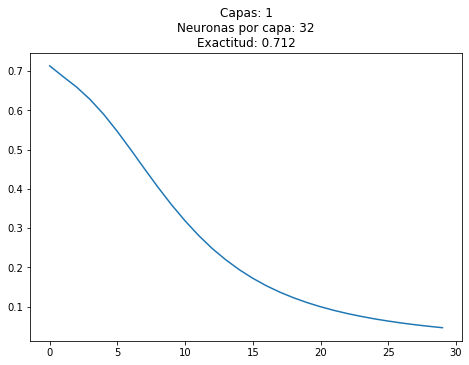

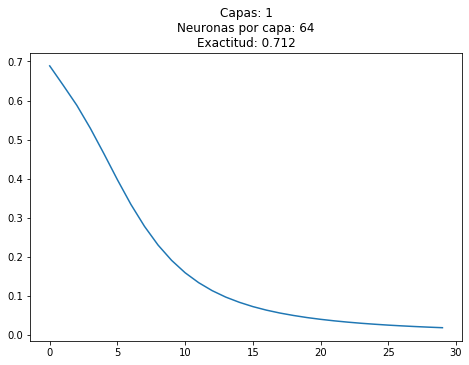

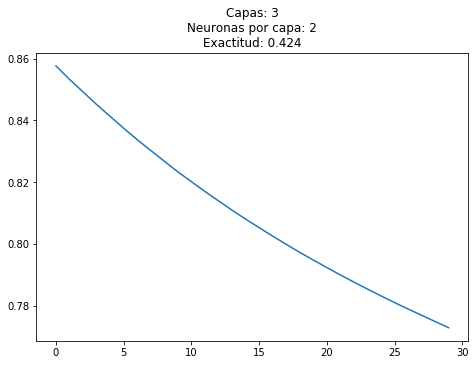

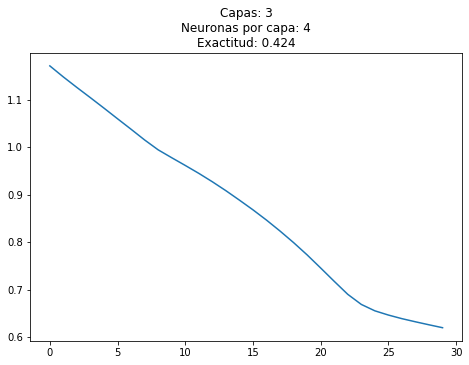

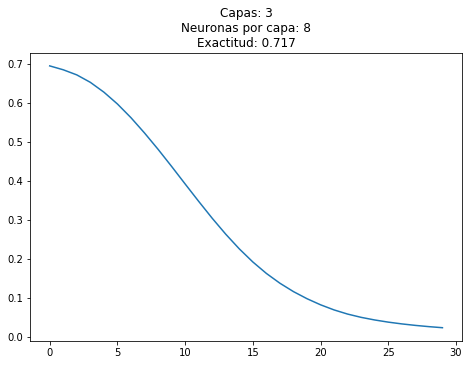

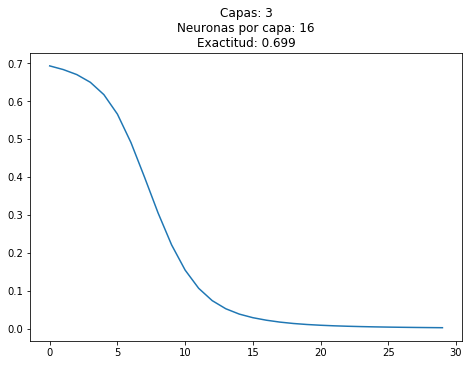

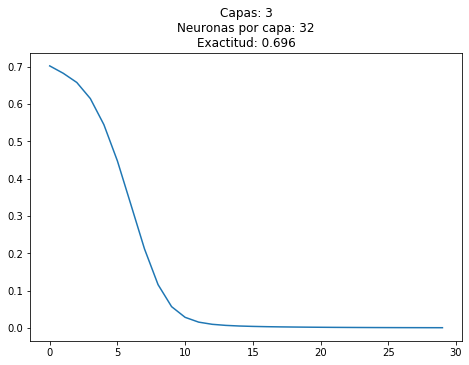

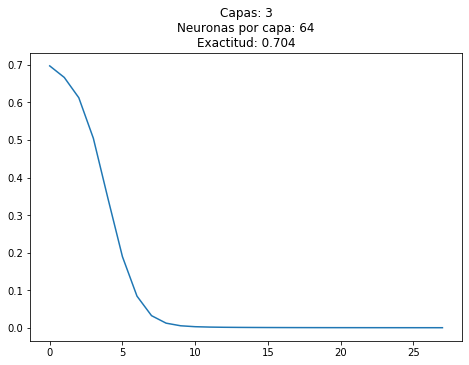

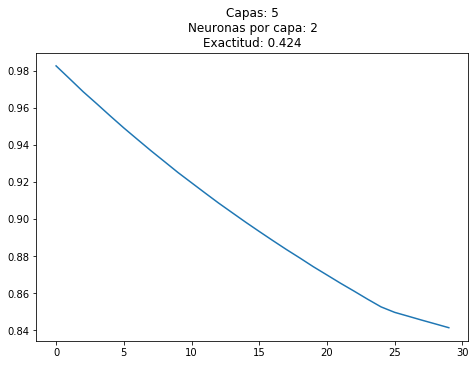

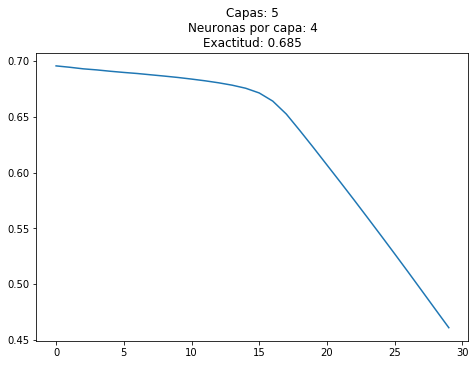

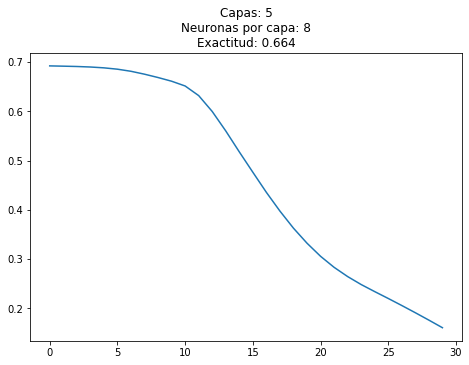

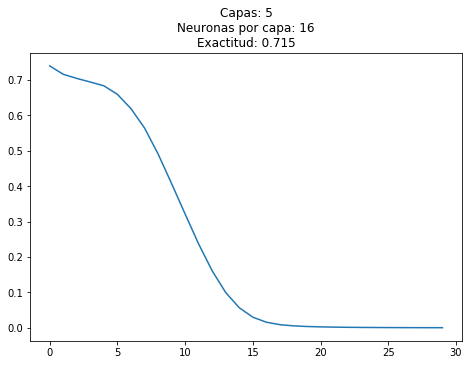

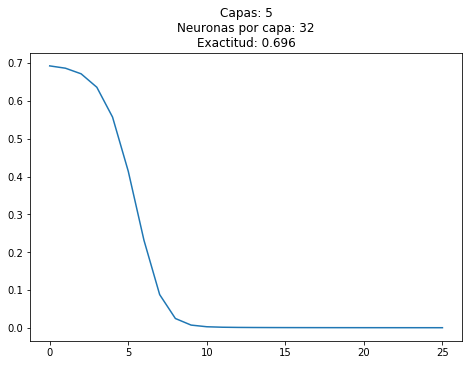

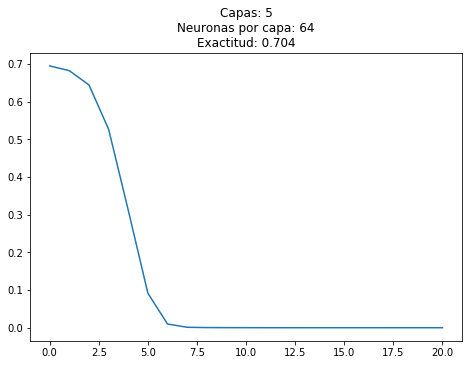

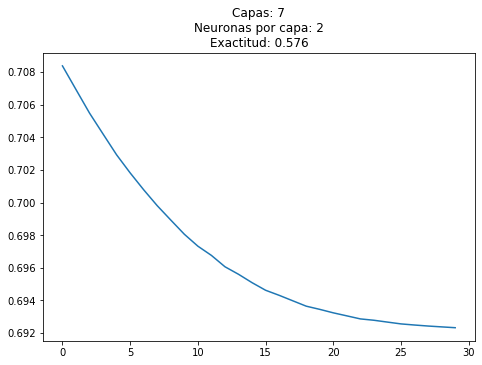

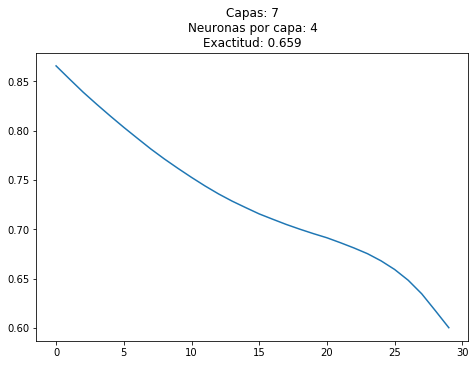

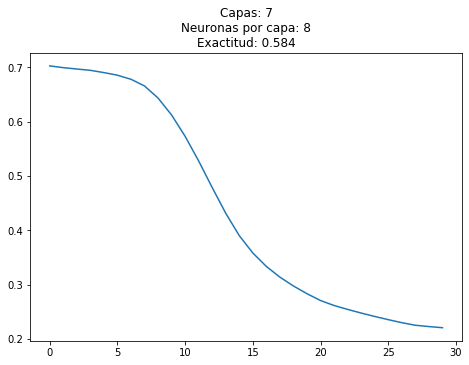

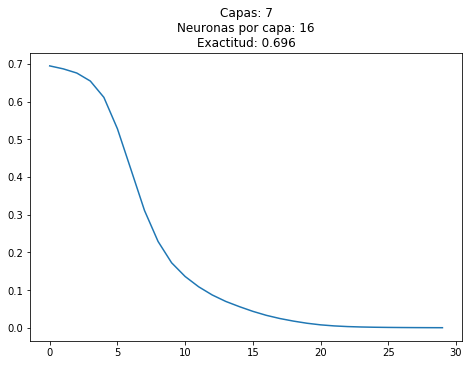

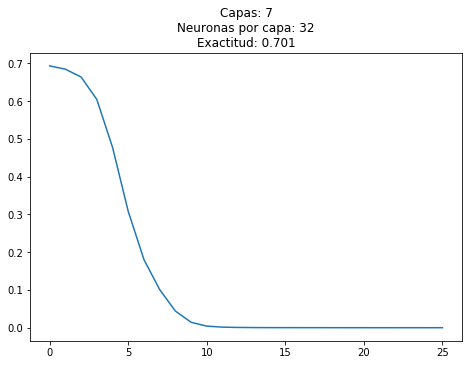

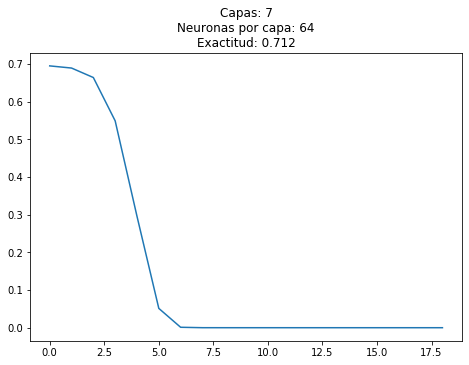

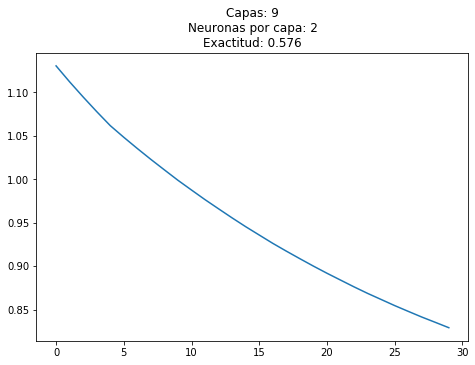

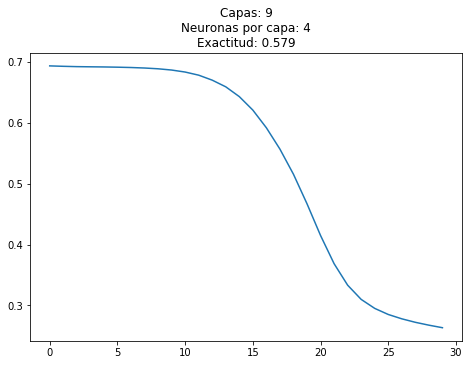

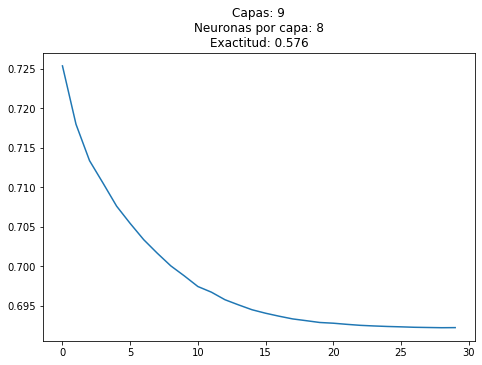

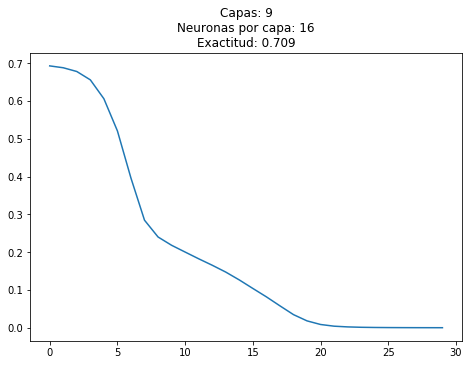

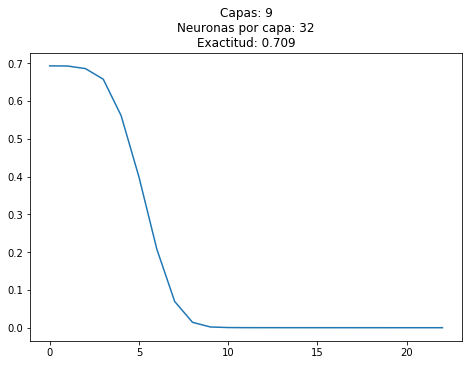

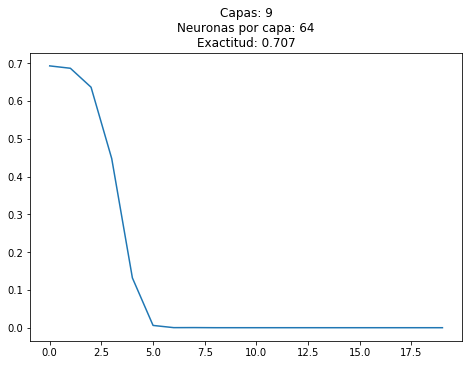

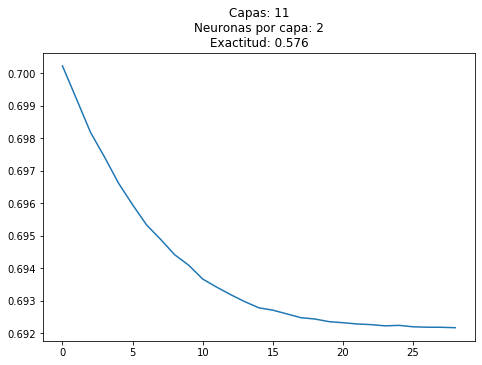

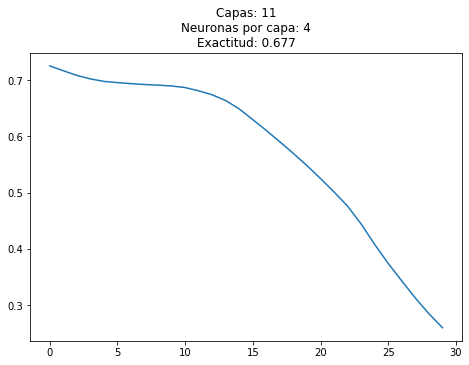

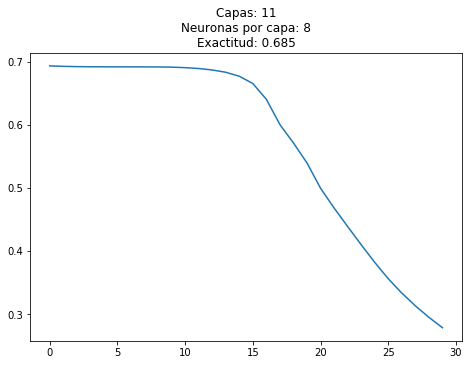

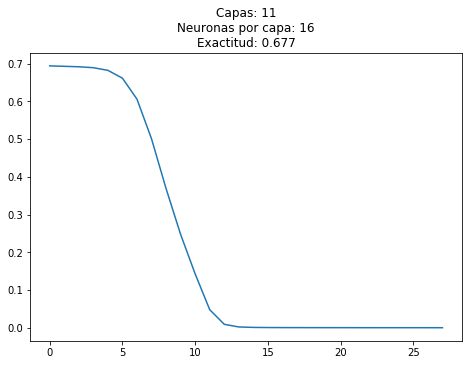

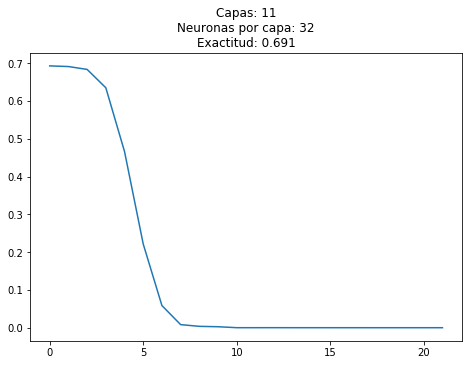

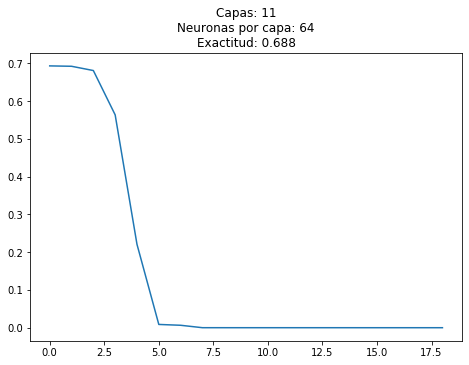

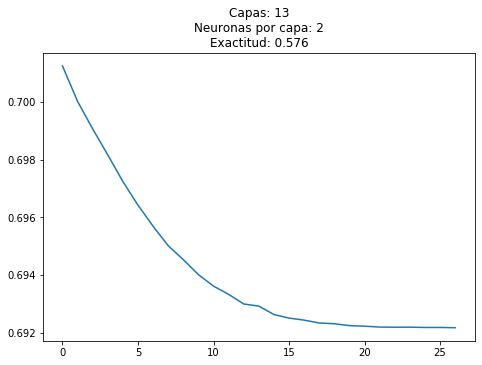

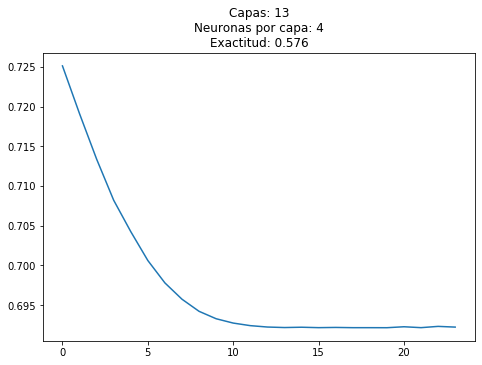

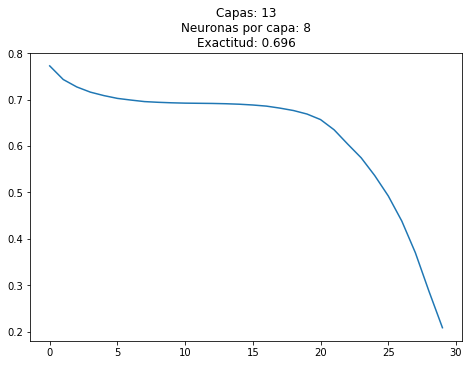

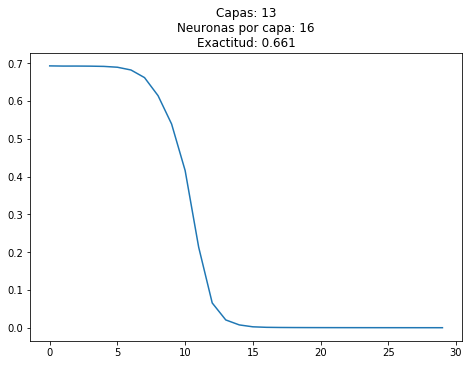

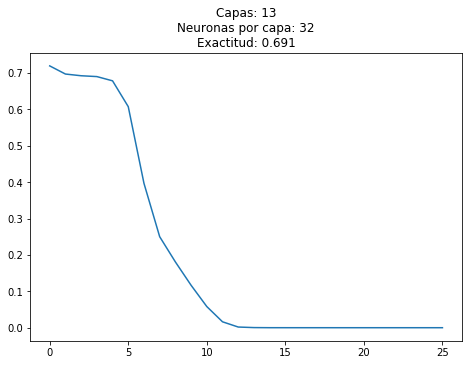

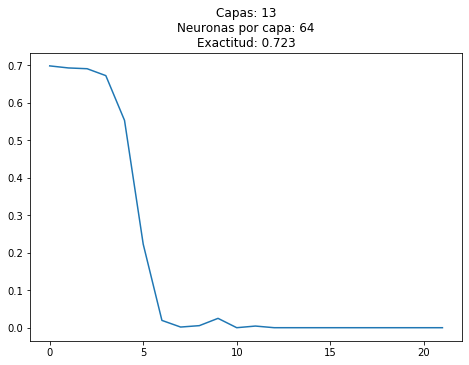

In [35]:
%matplotlib inline

layers = [x for x in range(1, 15, 2)]
neurons = [2 ** x for x in range(1, 7)]

for layer in layers:
    for neuron in neurons:
        train_and_plot([neuron for _ in range(layer)], x_train_clean, y_train_clean, x_val_clean, y_val_clean)

Se puede observar que mientras neuronas tiene cada capa, se logra reducir el error en el set de entrenamiento con mayor rapidez. Con una baja cantidad de neuronas, se obtiene una menor exactitud.
La cantidad de capas no pareció afectar den gran manera el rendimiento del modelo.

## Actividad 6: Análisis de Redes Neuronales

Según los gráficos anteriores, el mejor rendimiento se obtuvo con **3 capas** con **16 neuronas** cada una. En las pruebas con el test de validación, la exactitud fue de **0.715**

/home/rafael/.local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


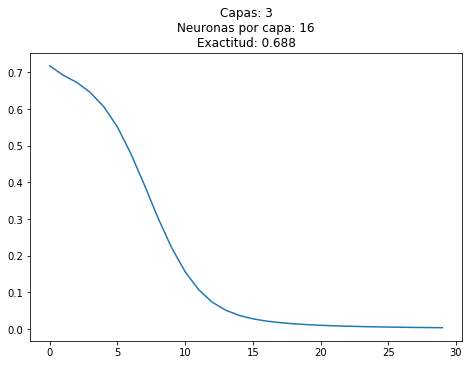

In [36]:
train_and_plot([16, 16, 16], x_train_clean, y_train_clean, x_test_clean, y_test_clean)

Mientras que la exactitud en el set de test fue de **0.696**. Como se dijo anteriormente, la cantidad de capas no causó una gran influencia en el rendimiento, mientras que a mayor numero de neuronas se observó una mayor exactitud y una menor cantidad de generaciones en reducir el error del set de entrenamiento.


Cabe mencionar que los rendimientos fueron similares a los obtenidos con SVM.

## Actividad 7: Resultados Redes neuronales


In [37]:
mlp = MLPClassifier(hidden_layer_sizes=[16, 16, 16], max_iter=30)
mlp.fit(x_train, y_train)
y_pred = mlp.predict(x_test)

/home/rafael/.local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [38]:
correct = [(val, y_test[index]) for index, val in enumerate(x_test_original) 
           if y_pred[index] == y_test[index]]

correct_true = [title for title, class_ in correct if class_]
correct_false = [title for title, class_ in correct if not class_]

incorrect = [(val, y_test[index]) for index, val in enumerate(x_test_original)
             if y_pred[index] != y_test[index]]
incorrect_true = [title for title, class_ in incorrect if class_]
incorrect_false = [title for title, class_ in incorrect if not class_]

In [39]:
LIMIT = 10

print("---- CORRECTAMENTE CLASIFICADAS -----")
print("---> IRÓNICAS")
print("\n".join(correct_true[:LIMIT]) + "\n")
print("---> NO IRÓNICAS")
print("\n".join(correct_false[:LIMIT]) + "\n")
print("-" * 40 + "\n")
print("---- INCORRECTAMENTE CLASIFICADAS -----")
print("---> IRÓNICAS")
print("\n".join(incorrect_true[:LIMIT]) + "\n")
print("---> NO IRÓNICAS")
print("\n".join(incorrect_false[:LIMIT]) + "\n")

---- CORRECTAMENTE CLASIFICADAS -----
---> IRÓNICAS
romney we should never apologize for american values or japanese internment camps
nation to try channeling outrage over gun control into issue that can actually be addressed
outdoor movie guest excited to watch barely audible back to the future while sitting on tree root
gaunt, weathered john kerry leads prisoner uprising in siberian labor camp
obama returns from trade summit with 5 stout ships full of cardamom, silk, and indigo
shy congressman wishes other lawmakers would include him in their crimes
obama urges young voters to ignore how many lousy candidates democratic party runs
panicked billy graham realizes he took wrong turn into heavens largest gay neighborhood
man wearing jewmerica t-shirt never dreamed hed see this day
department of agriculture locates perfect goat

---> NO IRÓNICAS
boardroom hokey pokey that dance that women do
supreme court justices to snowstorm jonas its just ice
white house probes kushner business loans a

In [ ]:
Se puede observar que no hay gran diferencia en las predicciones de Redes Neuronales y SVM. Sin embargo, fue más fácil obtener exactitudes relativamente altas con redes neuronales